In [1]:
import os
import pandas as pd
import sklearn.tree as tree
import warnings
from pandas_profiling import ProfileReport
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

In [2]:
DATA_ROOT = 'dataset'
FIGURE_ROOT = 'figure'
FILENAME = 'character-deaths.csv'

df = pd.read_csv(os.path.join(DATA_ROOT, FILENAME))
df.head(3)

,Name,Allegiances,Death Year,Book of Death,Death Chapter,Book Intro Chapter,Gender,Nobility,GoT,CoK,SoS,FfC,DwD
0,Addam Marbrand,Lannister,NaN,NaN,NaN,56.0,1,1,1,1,1,1,0
1,Aegon Frey (Jinglebell),None,299.0,3.0,51.0,49.0,1,1,0,0,1,0,0
2,Aegon Targaryen,House Targaryen,NaN,NaN,NaN,5.0,1,1,0,0,0,0,1


In [3]:
profile = ProfileReport(df, title='Game_of_Thrones', explorative=True)
profile.to_file('Game_of_Thrones.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 201.56it/s]


In [4]:
class DataPreProcess:
    def __init__(self, df):
        self.df = df.copy()

    # Name	Allegiances	Death Year	Book of Death	Death Chapter	Book Intro Chapter	Gender	Nobility	GoT	CoK	SoS	FfC	DwD
    def drop_columns(self, columns=["Name", "Death Chapter", "Death Year"]):
        self.df = self.df.drop(columns, axis=1)

        return None
    
    def fill_missing_data(self):
        # df["Book of Death"].notna()
        self.df = self.df.fillna({ "Book of Death": 0})
        self.df["Book of Death"][self.df["Book of Death"]>0]=1
        self.df = self.df.fillna(1)

        return None

    def category_to_one_hot_encode(self):
        self.df = self.df.join(pd.get_dummies(self.df["Allegiances"]))
        self.df = self.df.drop(["Allegiances"], axis=1)
        # self.df = pd.get_dummies(self.df)

        return None

    def mod_data_type(self):
        # self.df["Book Intro Chapter"] = self.df["Book Intro Chapter"].astype('float32')
        pass

        return None

    def feature_transform(self):
        self.drop_columns()
        self.fill_missing_data()
        self.category_to_one_hot_encode()
        # self.mod_data_type()

        return None

    def train_test_split(self, X, y):
        sss = StratifiedShuffleSplit(n_splits=1, train_size=0.75, test_size=0.25, random_state=42)
        for train_indx, test_index in sss.split(X, y):
            self.X_train, self.y_train = X.iloc[train_indx], y.iloc[train_indx]
            self.X_test, self.y_test = X.iloc[test_index], y.iloc[test_index]


        return None
    
    def get_data(self, is_train=True):
        self.feature_transform()
        X = self.df.drop(labels=['Book of Death'], axis=1)
        y = (self.df['Book of Death']>0).astype(int)
        self.train_test_split(X, y)
        
        return None
        # if is_train:return (X,y)
        # else: return X

In [5]:
data = DataPreProcess(df)
data.get_data(is_train=True)
# train_preprocess = DP.get_data(is_train=True)
# X, y = train_preprocess

In [6]:
data.y_test.value_counts('Book of Death'), data.y_train.value_counts('Book of Death')
# np.unique(data.y_train)
# np.unique(data.y_test)

(0    0.665217
 1    0.334783
 Name: Book of Death, dtype: float64,
 0    0.665211
 1    0.334789
 Name: Book of Death, dtype: float64)

In [7]:
class DecisionTree(DataPreProcess):
    def __init__(self, data, max_depth=4, random_state=42):
        self.data = data
        self.max_depth=max_depth
        self.random_state=random_state
        self.__call__()

    def __call__(self):
        clf = DecisionTreeClassifier(max_depth=self.max_depth,
                                     random_state=self.random_state)
        clf = clf.fit(self.data.X_train, self.data.y_train)
        test_score = clf.score(self.data.X_test, self.data.y_test)
        train_score = clf.score(self.data.X_train, self.data.y_train)

        # if you did some search before, then get the best model
        # and assigned to the variable self.model to save it
        self.model = clf.fit(self.data.X_train, self.data.y_train)
        print(f"The training score is {train_score:.4f}, and the test score is {test_score:.4f}")
        
        return None


class Evaluate():
    def __init__(self, PD, GT):
        self.TN, self.FP, self.FN, self.TP = confusion_matrix(PD, GT).ravel()
        self.precision = self.TP / (self.TP + self.FP)
        self.recall    = self.TP / (self.TP + self.FN)
        self.sensitivity = self.recall
        self.specificity = self.TN / (self.TN + self.FP)
        self.accuracy = (self.TP + self.TN) / (self.TN + self.FP + self.FN + self.TP)

    def print_confusion_matrix(self):
        print("Row major : TP, FP, FN, TN")
        print(f"""
        [[{self.TP:4d}, {self.FP:4d}],
         [{self.FN:4d}, {self.TN:4d}]]
        """)

        return None

    def print_precision_recall(self):
        print(f"Precision: {self.precision:.5f}")
        print(f"Recall:    {self.recall:.5f}")
        print(f"Accuracy:  {self.accuracy:.5f}")
        
        return None

    def print_sensitivity_specitivity(self):
        print(f"Sensitivity: {self.sensitivity:.5f}")
        print(f"Specitivity: {self.specificity:.5f}")
        print(f"Accuracy:    {self.accuracy:.5f}")

        return None

    def print_all(self):
        print(f"Precision:   {self.precision:.5f}")
        print(f"Recall:      {self.recall:.5f}")
        print(f"Sensitivity: {self.sensitivity:.5f}")
        print(f"Specitivity: {self.specificity:.5f}")
        print(f"Accuracy:    {self.accuracy:.5f}")

        return None



In [8]:
ML_DT = DecisionTree(data)
data.y_train_prediction = ML_DT.model.predict(data.X_train)
data.y_test_prediction = ML_DT.model.predict(data.X_test)
eva_train = Evaluate(data.y_train_prediction, data.y_train)
eva_test = Evaluate(data.y_test_prediction, data.y_test)
eva_test.print_confusion_matrix()
eva_test.print_all()



The training score is 0.7365, and the test score is 0.6696
Row major : TP, FP, FN, TN

        [[  38,   39],
         [  37,  116]]
        
Precision:   0.49351
Recall:      0.50667
Sensitivity: 0.50667
Specitivity: 0.74839
Accuracy:    0.66957


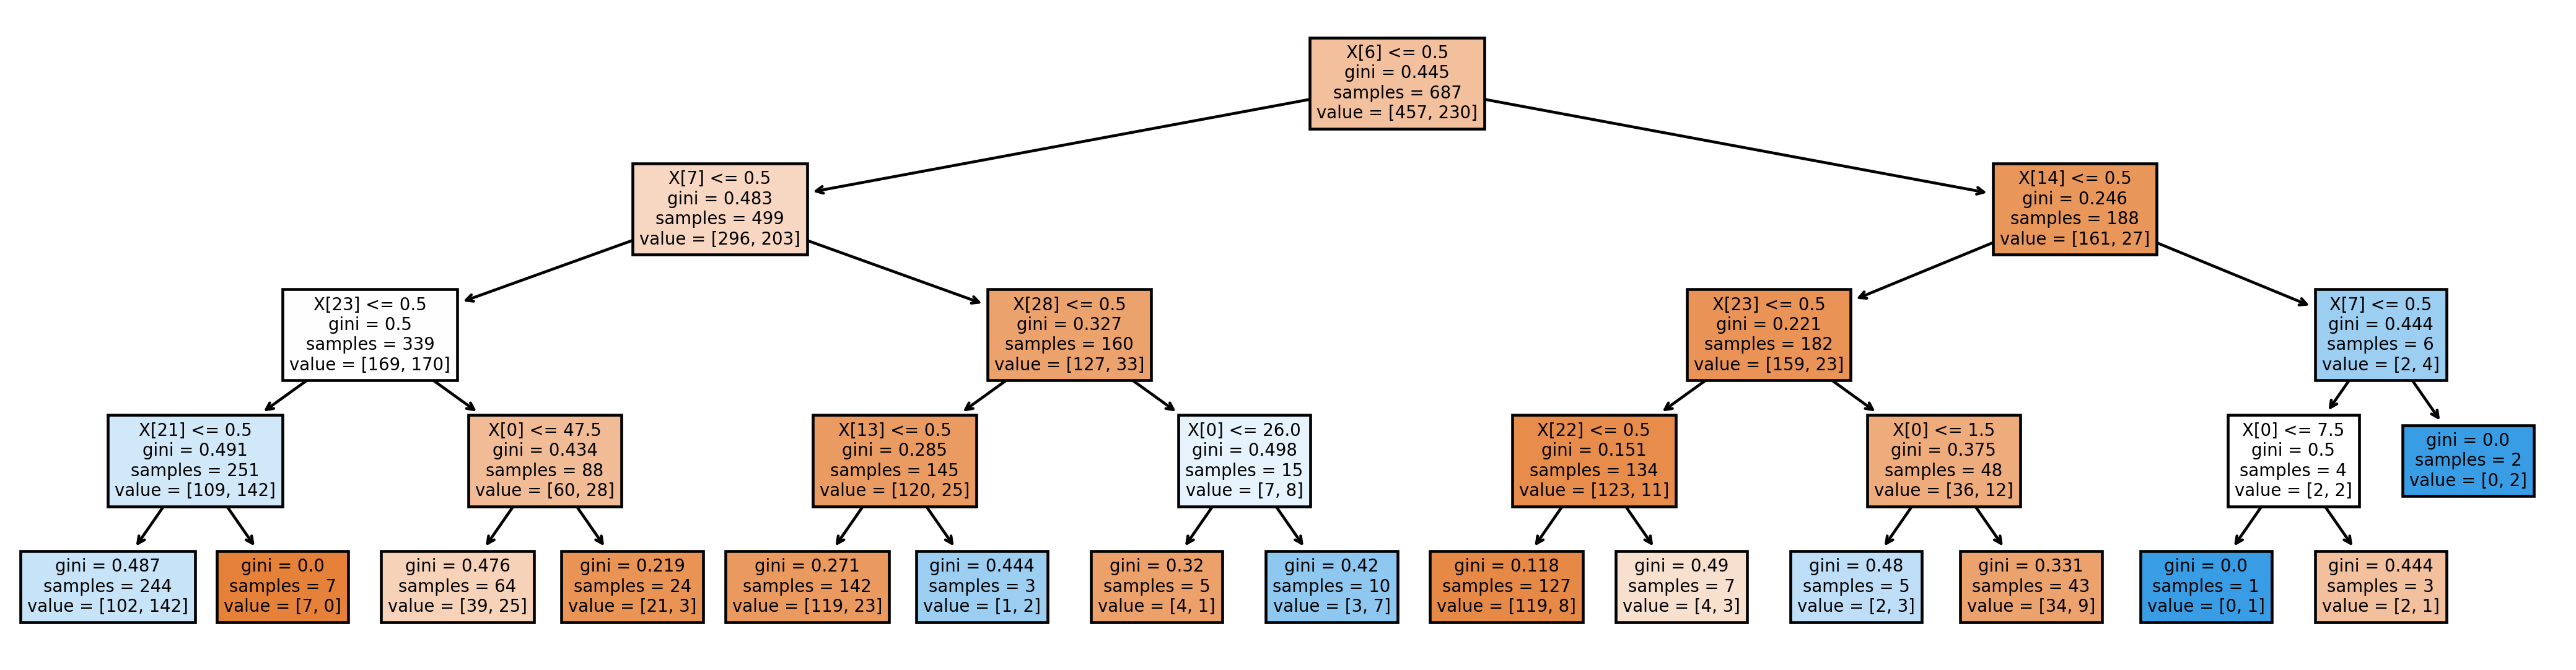

In [9]:
fig = plt.figure(figsize=(16,4), dpi=330)
tree.plot_tree(ML_DT.model, filled=True)
fig.savefig(os.path.join(FIGURE_ROOT, 'decision_tree_visualize.png'))

In [10]:
# import graphviz  
# dot_data = tree.export_graphviz(ML_DT.model, out_file=None, 
#                   feature_names=list(data.X_train.columns.values),  
#                   class_names=list(data.y_train.name),
#                   filled = True,
#                   rounded = True,
#                   special_characters = True)

# graph = graphviz.Source(dot_data)
# graph.render('mygraph',view = True, format='jpg')

# # graph